In [24]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

## 데이터 불러오기

In [46]:
# 학습 데이터
train = pd.read_csv('detect_ai_generated_text/dataset/train_essays.csv')
test = pd.read_csv('detect_ai_generated_text/dataset/test_essays.csv')
prompt = pd.read_csv('detect_ai_generated_text/dataset/train_prompts.csv')

In [7]:
train.head(3)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0


In [8]:
test.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [9]:
prompt.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


## EDA
* 데이터셋 확인
* 결측치 확인
* 데이터 시각화

### 데이터 확인

In [10]:
# 데이터 정보 확인
train.info()
print("\n학습 데이터 갯수: ", train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB

학습 데이터 갯수:  (1378, 4)


In [13]:
prompt.info()
print("\n프롬프트 데이터 갯수: ", train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes

프롬프트 데이터 갯수:  (1378, 4)


In [12]:
# 결측치 확인
train.isnull().sum()

id           0
prompt_id    0
text         0
generated    0
dtype: int64

In [14]:
test.isnull().sum()

id           0
prompt_id    0
text         0
dtype: int64

In [15]:
prompt.isnull().sum()

prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64

target 분포 확인

In [16]:
train['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [17]:
llm_generated_counts = train[train['generated'] == 1]['prompt_id'].value_counts()
llm_generated_counts

prompt_id
1    2
0    1
Name: count, dtype: int64

### 에세이 본문 분석 및 시각화
* 텍스트 길이
* 단어
* 프롬프트 연관성 

#### 텍스트 길이 시각화 및 통계량 확인

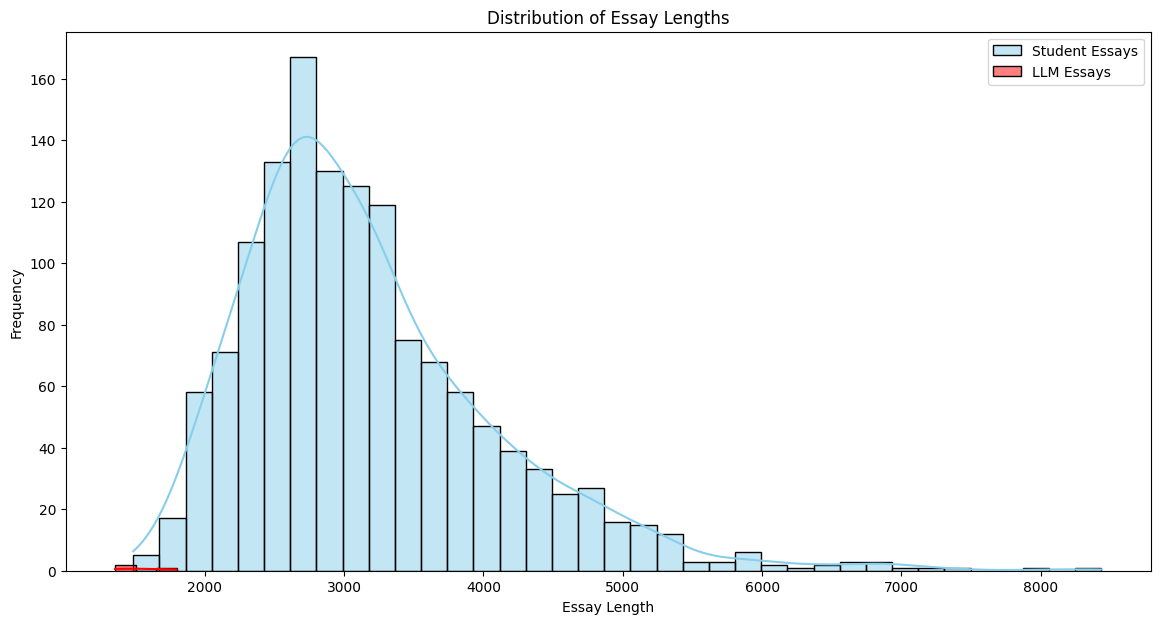

In [20]:
# text 열의 길이를 기반으로 essay_length 열 생성
train['essay_length'] = train['text'].apply(len)

plt.figure(figsize=(14, 7))

# 학생 에세이 길이 분포
sns.histplot(train[train['generated'] == 0]['essay_length'], color="skyblue", label='Student Essays', kde=True)

# LLM 에세이 길이 분포
sns.histplot(train[train['generated'] == 1]['essay_length'], color="red", label='LLM Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

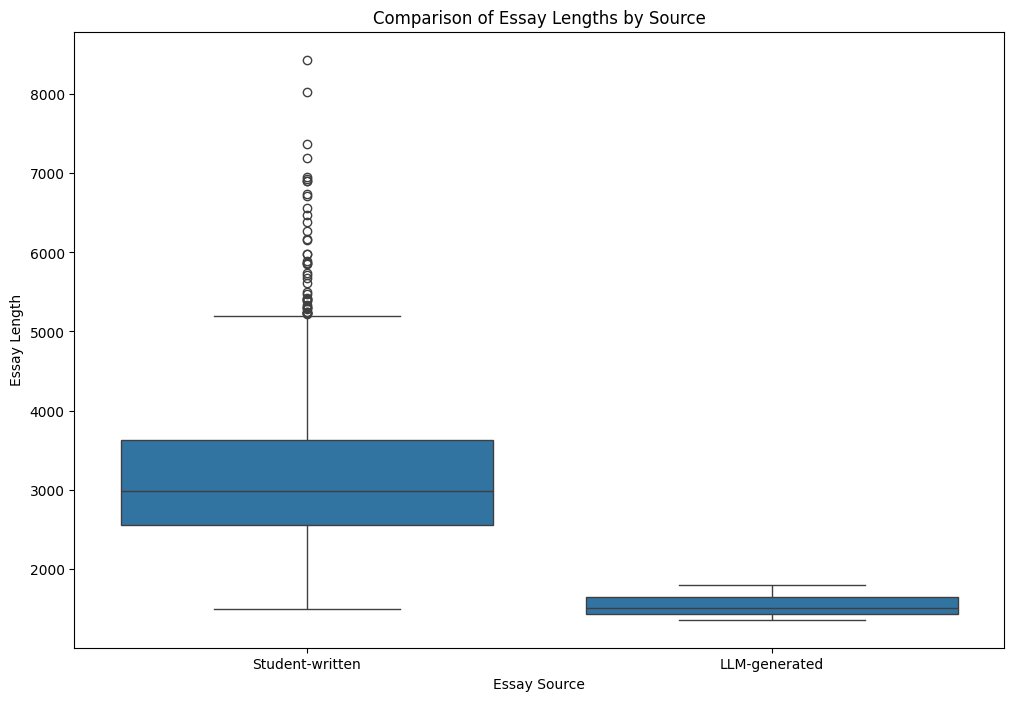

In [19]:
# 에세이 길이 비교 시각화
plt.figure(figsize=(12, 8))
sns.boxplot(x='generated', y='essay_length', data=train)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student', 'LLM'])
plt.show()

In [21]:
# 텍스트 메트릭 계산 함수
def calculate_text_metrics_simple(text):
    # 공백 기준으로 단어 분리
    words = text.split()
    # 마침표 기준으로 문장 분리
    sentences = text.split('.')
    # 단어 갯수
    word_count = len(words)
    unique_word_count = len(set(words))
    # 문장 갯수
    sentence_count = len(sentences)
    # 평균 단어 길이
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    return word_count, unique_word_count, sentence_count, avg_word_length

In [22]:
# 텍스트 메트릭 계산
train['metrics'] = train['text'].apply(calculate_text_metrics_simple)

# 메트릭 열 분해
train[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']] = pd.DataFrame(train['metrics'].tolist(), index=train.index)

# 메트릭 열 삭제
train.drop('metrics', axis=1, inplace=True)

In [23]:
# 학생 에세이와 LLM 에세이 메트릭 비교
comparison_metrics = train.groupby('generated')[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']].mean()
comparison_metrics

,word_count,unique_word_count,sentence_count,avg_word_length
generated,,,,
0,556.768727,275.334545,30.063273,4.694868
1,260.666667,146.333333,13.000000,4.935610


#### 빈도수가 높은 단어 시각화

In [27]:
def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
    # 모든 텍스트를 소문자로 변환하고 공백으로 분리
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)
    
    # 가장 빈도수가 높은 단어 시각화
    plt.figure(figsize=(15, 7))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

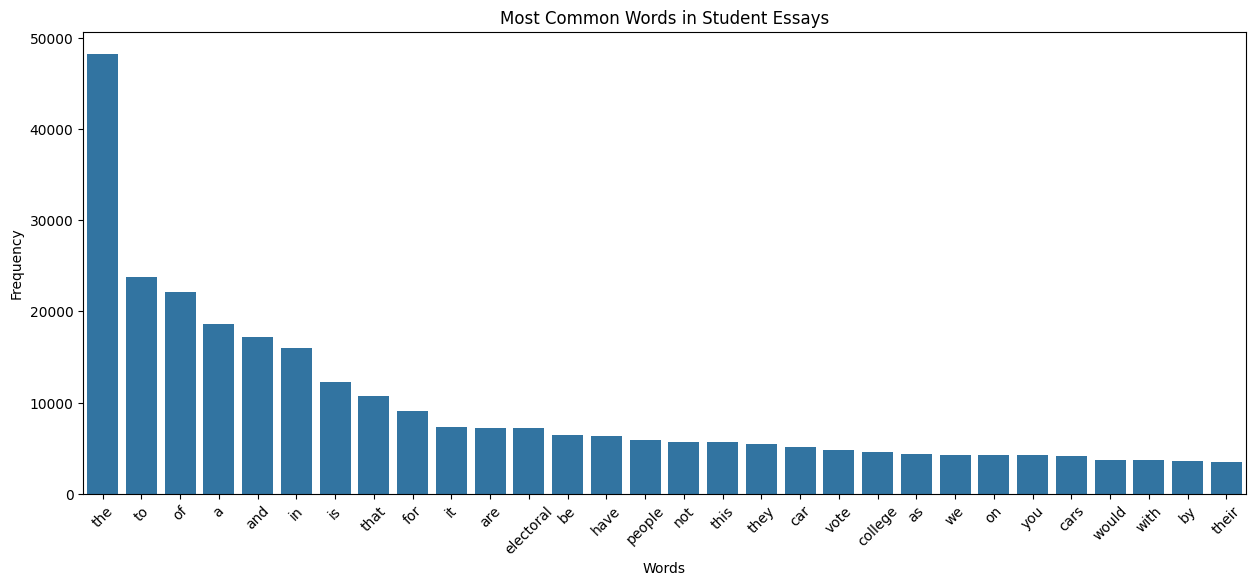

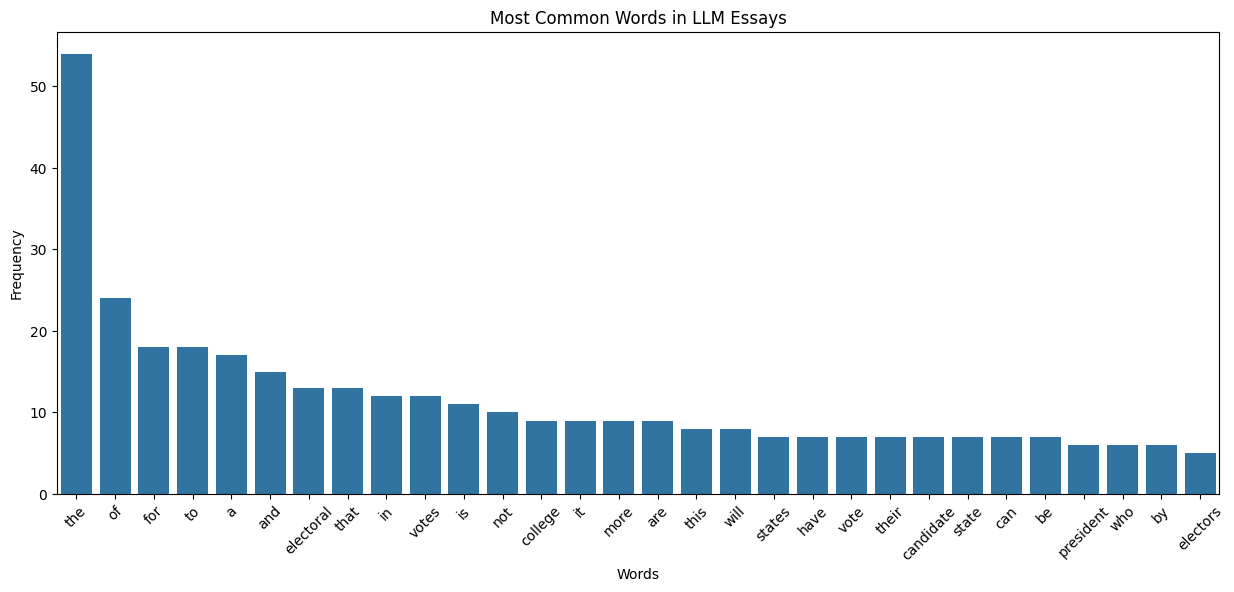

In [26]:
plot_most_common_words(train[train['generated'] == 0]['text'], title="Most Common Words in Student Essays")
plot_most_common_words(train[train['generated'] == 1]['text'], title="Most Common Words in LLM Essays")

#### 프롬프트와 에세이 연관성 확인 및 시각화

In [29]:
# text 열의 길이를 기반으로 essay_length 열 생성
train['essay_length'] = train['text'].apply(len)

# 프롬프트 데이터프레임과 병합
merged_df = train.merge(prompt, on='prompt_id', how='left')

# 프롬프트 빈도 분석
prompt_usage = merged_df['prompt_id'].value_counts()

# 프롬프트별 평균 에세이 길이
avg_length_by_prompt = merged_df.groupby('prompt_id')['essay_length'].mean()

In [30]:
# 프롬프트 빈도 표시
display("Prompt Usage Frequency")
display(prompt_usage)

'Prompt Usage Frequency'

prompt_id
0    708
1    670
Name: count, dtype: int64

In [31]:
# 프롬프트별 평균 에세이 길이 표시
display("Average Essay Length by Prompt")
display(avg_length_by_prompt)

'Average Essay Length by Prompt'

prompt_id
0    3251.927966
1    3081.473134
Name: essay_length, dtype: float64

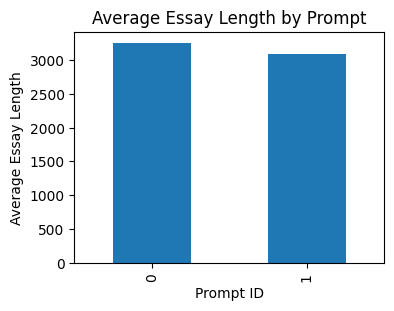

In [34]:
# 프롬프트별 평균 에세이 길이 시각화
plt.figure(figsize=(4, 3))

avg_length_by_prompt.plot(kind='bar')

plt.title('Average Essay Length by Prompt')
plt.xlabel('Prompt ID')
plt.ylabel('Average Essay Length')
plt.show()

In [41]:
# 프롬프트 키워드 시각화
def plot_top_keywords(data, column, num_keywords=10):
    # 영어 불용어 제거
    vec = CountVectorizer(stop_words='english').fit(data[column])
    bag_of_words = vec.transform(data[column])

    # 단어 빈도 계산
    sum_words = bag_of_words.sum(axis=0) 

    # 단어 빈도 정렬
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    # 상위 키워드 선택
    top_words = words_freq[:num_keywords]
    print("\ntop_words:", [word for word, _ in top_words])

    # 데이터프레임 변환
    top_df = pd.DataFrame(top_words, columns=['Keyword', 'Frequency'])
    
    # 막대 그래프 시각화
    plt.figure(figsize=(7,4))
    sns.barplot(x='Frequency', y='Keyword', data=top_df)
    plt.title(f'Top {num_keywords} Keywords in {column}')
    plt.show()


top_words: ['electoral', 'vote', 'electors', 'car', 'college', 'president', 'state', 'election', 'votes', 'cars']


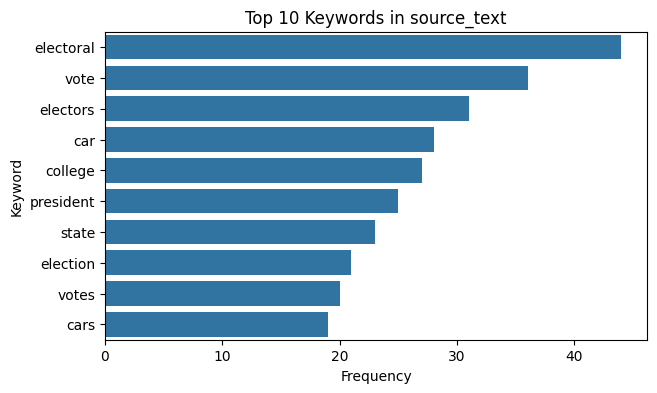

In [42]:
# 프롬프트 키워드 시각화
plot_top_keywords(prompt, 'source_text')


top_words: ['electoral', 'people', 'college', 'vote', 'car', 'cars', 'states', 'president', 'votes', 'electors']


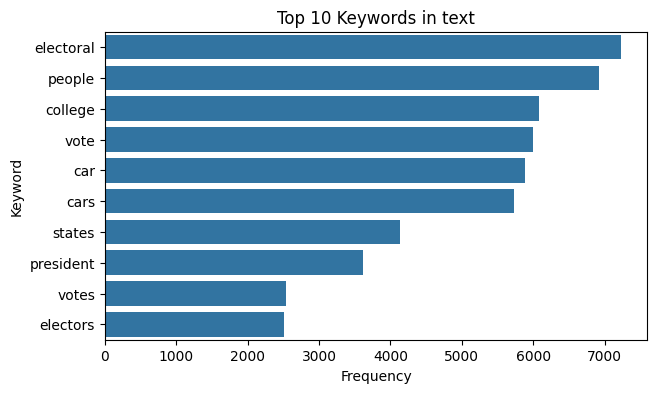

In [43]:
# 에세이 키워드 시각화
plot_top_keywords(train, 'text')

필사 Notebook
----
[4rd Place Solution](https://www.kaggle.com/code/chasembowers/4th-place-solution/notebook)

In [ ]:
!pip install -q -U accelerate --no-index --find-links ../input/llm-detect-pip/
!pip install -q -U bitsandbytes --no-index --find-links ../input/llm-detect-pip/
!pip install -q -U transformers --no-index --find-links ../input/llm-detect-pip/

In [ ]:
!pip install /kaggle/input/llm-science-exam-lib-ds/keras_core-0.1.7-py3-none-any.whl --no-deps
!pip install /kaggle/input/llm-science-exam-lib-ds/keras_nlp-0.6.2-py3-none-any.whl --no-deps

In [ ]:
# 필요한 라이브러리 불러오기
import sys
import gc
import time 
import os
import itertools
import regex as re
import random
import pickle
import torch

import ctypes
libc = ctypes.CDLL("libc.so.6")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import make_scorer, accuracy_score
from scipy.sparse import csr_matrix, vstack, hstack

from concurrent.futures import ProcessPoolExecutor

In [ ]:
# 랜덤 시드 설정
seed = 202

# 테스트 데이터 누락 수정 여부
isFixTestLeakage = True

# 문장 구문 수정 여부
isCorrectSentence = True

In [ ]:
# 케라스 백엔드 설정
os.environ["KERAS_BACKEND"] = "torch"

import keras_core as keras 
import keras_core.backend as K
import jax

import tensorflow as tf

from glob import glob

In [ ]:
def seed_everything(seed=2023):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(seed)

## 데이터 불러오기 및 전처리

In [ ]:
# 패치 제출 여부
FAKE_SUBMISSION = True

# 테스트 데이터 불러오기
test = pd.read_csv('detect_ai_generated_text/dataset/test_essays.csv')

# 검증 데이터 불러오기
daigt2_val = pd.read_csv("detect_ai_generated_text/dataset/daigt2-wo-official-with-prompt-id/validation.csv")
daigt2_val.reset_index(drop=True, inplace=True)

# 라이브 제출 여부
IS_LIVE_SUBMISSION = True

# 팔로워 모델 가중치
FOLLOWER_MODEL_WEIGHT = 1.1

# 모델 캐시 초기화
mistral_heuristic_cache = None
ertugrul_deberta_cache = None

# 라이브 제출 여부에 따라 데이터 불러오기
if IS_LIVE_SUBMISSION:
    daigt2_train = pd.read_csv("detect_ai_generated_text/dataset/typo_intro/typo_intro.csv", sep=',')
    daigt2_train = daigt2_train.drop_duplicates(subset=['text'])
    daigt2_train.reset_index(drop=True, inplace=True)
    test = test
    # 최대 예측 데이터 수
    MAX_EXAMPLES_TO_PREDICT = 1000000
    # GBM 반복 비율
    GBOOST_ITERATION_FRACTION = 1
    # SVC 배깅 비율
    SVC_BAGGING_FRACTION = .3

# 패치 제출 여부에 따라 데이터 불러오기
else:    
    if FAKE_SUBMISSION:
        if not torch.cuda.is_available(): raise RuntimeError("CUDA is not available.")
        
        # 제출 데이터프레임 생성
        sub = pd.DataFrame({'id':[],'generated':[]})
        sub.to_csv('submission.csv', index=False)
        sys.exit()
        
    # 트레이닝 데이터 불러오기
    daigt2_train = pd.read_csv("detect_ai_generated_text/dataset/typo_intro/typo_intro.csv", sep=',')
    daigt2_train.reset_index(drop=True, inplace=True)

    # 캐시 초기화
    mistral_heuristic_cache = {}
    with open("/kaggle/input/jan13-quantile-string-mistral-cache/jan_13_test_quantiles.pkl", 'rb') as quantiles_pickle_file:
        mistral_heuristic_cache["test"] = pickle.load(quantiles_pickle_file)
        
    # 캐시 초기화
    with open("/kaggle/input/erturgrul-deberta-preds-cache-jan16/ertugrul_deberta_predictions.pkl", 'rb') as deberta_preds_file:
        ertugrul_deberta_cache = pickle.load(deberta_preds_file)

    # 테스트 데이터 불러오기
    test = pd.read_csv("detect_ai_generated_text/dataset/daigt2-wo-official-with-prompt-id/test_no_label.csv")
    # 최대 예측 데이터 수
    MAX_EXAMPLES_TO_PREDICT = 1200
    # GBM 반복 비율
    GBOOST_ITERATION_FRACTION = .1
    # SVC 배깅 비율
    SVC_BAGGING_FRACTION = .1


In [ ]:
# 프롬프트 제외 리스트
excluded_prompt_name_list = ['Distance learning','Grades for extracurricular activities','Summer projects']
daigt2_train = daigt2_train[~(daigt2_train['prompt_name'].isin(excluded_prompt_name_list))]

# 중복 제거
daigt2_train = daigt2_train.drop_duplicates(subset=['text'])
daigt2_train.reset_index(drop=True, inplace=True)

In [ ]:
# 로지스틱 함수 정의
def safe_logodds(prob_arr):
    # 확률 클리핑
    clipped = np.clip(a=prob_arr, a_min=.001, a_max=.999)
    return np.log(clipped/(1-clipped))

## 학습 및 예측

### Deberta 모델 설정 및 예측

In [ ]:
from dataclasses import dataclass
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import transformers
from sklearn.metrics import roc_auc_score


In [ ]:
# 캐시 초기화
torch.cuda.empty_cache()

In [ ]:
# deberta 모델 캐시 초기화
if ertugrul_deberta_cache is None:

    # deberta 모델 설정
    @dataclass
    class ertugrul_debert_cfg:
        transformer_name = "/kaggle/input/huggingfacedebertav3variants/deberta-v3-large"
        batch_size = 8
        max_len = 1024
        n_classes = 1

    # deberta 토크나이저 초기화
    ertugrul_debert_tokenizer = AutoTokenizer.from_pretrained(ertugrul_debert_cfg.transformer_name)

    # deberta 텍스트 전처리
    def ertugrul_deberta_prepare_input(text):
        inputs = ertugrul_debert_tokenizer.encode_plus(
            text, 
            return_tensors=None, 
            add_special_tokens=True, 
            max_length=ertugrul_debert_cfg.max_len,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )
        # 텐서 변환
        for k, v in inputs.items():
            inputs[k] = torch.tensor(v, dtype=torch.long)
        return inputs

    # deberta 데이터셋 클래스
    class ErtugrulDebertaTrainDataset(Dataset):
        def __init__(self, df):
            self.texts = df['text'].values

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, item):
            inputs = ertugrul_deberta_prepare_input(self.texts[item])
            return inputs

    # deberta 데이터셋 합치기
    def ertugrul_deberta_collate(inputs):
        mask_len = int(inputs["attention_mask"].sum(axis=1).max())
        for k, v in inputs.items():
            inputs[k] = inputs[k][:,:mask_len]
        return inputs

    # deberta 테스트 데이터셋 초기화
    ertugrul_deberta_test_dataset = ErtugrulDebertaTrainDataset(test)

    # deberta 모델 체크포인트 로드
    ertugrul_deberta_checkpoint = torch.load("/kaggle/input/deblarge-f0-999/last.ckpt")

    # 클래식 모델 클래스
    class ClassicFeed(torch.nn.Module):
        def __init__(self):
            super(ClassicFeed, self).__init__()

            self.transformer = AutoModel.from_pretrained(ertugrul_debert_cfg.transformer_name)
            self.classifier = torch.nn.Linear(self.transformer.config.hidden_size, 1)

        def forward(self, input_ids, attention_mask, token_type_ids):
            output = self.transformer(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            last_layer_hidden_states = output.last_hidden_state[:, 0, :]
            outputs = self.classifier(last_layer_hidden_states)
            return outputs

    # 클래식 모델 초기화
    classic_model = ClassicFeed()
    classic_model.load_state_dict(ertugrul_deberta_checkpoint['state_dict'])

    # 클래식 모델 평가 모드 설정
    classic_model.eval()
    # 클래식 모델 훈련 모드 설정
    trained_model = classic_model.to('cuda')
    # deberta 데이터로더 초기화
    ertugrul_deberta_dataloader = DataLoader(ertugrul_deberta_test_dataset, batch_size=ertugrul_debert_cfg.batch_size, shuffle=False)

    # deberta 예측 결과 초기화
    ertugrul_deberta_predictions = []

    # deberta 데이터로더 반복
    for batch in tqdm(ertugrul_deberta_dataloader, position=0, leave=True):

        batch = ertugrul_deberta_collate(batch)  
        for k, v in batch.items():
            batch[k] = v

        # 배치 데이터 초기화    
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        token_type_ids = batch['token_type_ids'].to('cuda')

        # deberta 모델 예측
        with torch.no_grad():
            deberta_pred = trained_model(input_ids, attention_mask, token_type_ids)

        # deberta 예측 결과 추가
        ertugrul_deberta_predictions.append(torch.sigmoid(deberta_pred))
        del batch

    # deberta 예측 결과 연결
    ertugrul_deberta_predictions = torch.cat(ertugrul_deberta_predictions).cpu().numpy()[:,0]

    # 클래식 모델 삭제
    del trained_model
    del classic_model
    gc.collect()
    torch.cuda.empty_cache()
    
else:
    # deberta 모델 캐시 사용
    ertugrul_deberta_predictions = ertugrul_deberta_cache


### 청크 모델 설정 및 예측

In [ ]:
# 청크 모델 초기화
chunk_model = AutoModelForSequenceClassification.from_pretrained(
    "/kaggle/input/longformer-predict-model-best-check",
)

# 청크 토크나이저 초기화
chunk_tokenizer = AutoTokenizer.from_pretrained(
    "/kaggle/input/longformer-predict-model-best-check"
)

# 청크 모델 훈련 모드 설정
chunk_model.to("cuda")

print("starting")
# 청크 모델 예측 결과 초기화
predict_model_features = []
for test_text in tqdm(test["text"].values):

    # 청크 토크나이저 테스트 텍스트 토크나이징
    tokenized_test_text = chunk_tokenizer(test_text, return_tensors="pt")

    # 청크 모델 입력 초기화
    input_ids = tokenized_test_text['input_ids'].to('cuda')
    attention_mask = tokenized_test_text['attention_mask'].to('cuda')

    # 청크 모델 예측
    with torch.no_grad():
        chunk_pred = safe_logodds(torch.softmax(chunk_model(input_ids, attention_mask).logits[0], dim=-1).cpu().numpy())
        predict_model_features.append(chunk_pred)

    # 청크 모델 예측 결과 삭제
    del chunk_pred
    


del chunk_model
gc.collect()
torch.cuda.empty_cache()

# 청크 모델 예측 결과 연결
predict_model_features = np.array(predict_model_features)


### mistral 모델 설정

In [ ]:
# mistral 모델 설정
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# mistral 모델 이름
model_name = "/kaggle/input/mistral/pytorch/7b-v0.1-hf/1"

# mistral 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# mistral 모델 초기화
model = None

# mistral 모델 캐시 초기화
if mistral_heuristic_cache is None:
    model = AutoModelForCausalLM.from_pretrained(
            model_name,
            load_in_4bit=True,
            quantization_config=bnb_config,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True,
        )

    model.config.pretraining_tp = 1 
    # 패드 토큰 아이디 설정
    model.config.pad_token_id = tokenizer.pad_token_id


### 휴리스틱 계산

In [ ]:
# 샘플링 함수 정의
def get_samples(logits, labels):
    # 로짓 차원 체크
    assert logits.shape[0] == 1
    # 라벨 차원 체크
    assert labels.shape[0] == 1
    # 샘플 수 설정
    nsamples = 10000
    # 로짓 소프트맥스
    lprobs = torch.log_softmax(logits, dim=-1)
    # 카테고리 분포 초기화
    distrib = torch.distributions.categorical.Categorical(logits=lprobs)
    # 샘플 샘플링
    samples = distrib.sample([nsamples]).permute([1, 2, 0])
    return samples

# 가능도 함수 정의
def get_likelihood(logits, labels):
    assert logits.shape[0] == 1
    assert labels.shape[0] == 1
    # 라벨 차원 체크
    labels = labels.unsqueeze(-1) if labels.ndim == logits.ndim - 1 else labels
    # 로짓 소프트맥스
    lprobs = torch.log_softmax(logits, dim=-1)
    # 로그 가능도 초기화
    log_likelihood = lprobs.gather(dim=-1, index=labels)
    return log_likelihood.mean(dim=1)

# 샘플링 불일치 함수 정의
def get_sampling_discrepancy(logits_ref, logits_score, labels):
    assert logits_ref.shape[0] == 1
    assert logits_score.shape[0] == 1
    assert labels.shape[0] == 1
    assert logits_ref.shape[1] == labels.shape[1]
    # 로짓 차원 체크
    if logits_ref.size(-1) != logits_score.size(-1):
        # 어휘 크기 불일치 체크
        vocab_size = min(logits_ref.size(-1), logits_score.size(-1))
        logits_ref = logits_ref[:, :, :vocab_size]
        logits_score = logits_score[:, :, :vocab_size]
    # 샘플 샘플링
    samples = get_samples(logits_ref, labels)
    # 로그 가능도 초기화
    log_likelihood_x = get_likelihood(logits_score, labels)
    # 로그 가능도 초기화
    log_likelihood_x_tilde = get_likelihood(logits_score, samples)
    # 평균 초기화
    miu_tilde = log_likelihood_x_tilde.mean(dim=-1)
    # 표준 편차 초기화
    sigma_tilde = log_likelihood_x_tilde.std(dim=-1)
    # 불일치 초기화
    discrepancy = (log_likelihood_x.squeeze(-1) - miu_tilde) / sigma_tilde
    return discrepancy.item(), log_likelihood_x.squeeze(-1), miu_tilde, sigma_tilde

# 샘플링 불일치 함수 정의
def get_sampling_discrepancy_analytic(logits_ref, logits_score, labels):
    assert logits_ref.shape[0] == 1
    assert logits_score.shape[0] == 1
    assert labels.shape[0] == 1
    assert logits_ref.shape[1] == labels.shape[1]
    # 어휘 크기 불일치 체크
    if logits_ref.size(-1) != logits_score.size(-1):
        raise Exception()

    assert labels.ndim == logits_score.ndim - 1
    labels = labels.unsqueeze(-1)
    
    lprobs_score = torch.log_softmax(logits_score, dim=-1)
    probs_ref = torch.softmax(logits_ref, dim=-1)
    log_likelihood = lprobs_score.gather(dim=-1, index=labels).squeeze(-1)
    
    # 평균 초기화
    mean_ref = (probs_ref * lprobs_score).sum(dim=-1)
    # 분산 초기화
    var_ref = (probs_ref * torch.square(lprobs_score)).sum(dim=-1) - torch.square(mean_ref)
    # 불일치 초기화
    discrepancy = (log_likelihood.sum(dim=-1) - mean_ref.sum(dim=-1)) / var_ref.sum(dim=-1).sqrt()
    # 불일치 평균
    discrepancy = discrepancy.mean()
    # 불일치, 평균, 분산 반환
    return discrepancy.item(), mean_ref.mean(dim=-1).item(), (var_ref.sum(dim=-1).sqrt() / mean_ref.shape[-1]).item()


### 언어 모델의 온도 매개변수

In [ ]:
import scipy.stats
class ImpliedTempScorer():

    def __init__(self, device="cuda"):
        # 정규 분포 초기화
        self.norm = scipy.stats.norm()
        # 샘플 수 설정
        self.num_samples = 60
        # 배치 크기 설정
        self.batch_size = 20
        # 가짜 정규 분포 샘플 초기화
        self.fake_normal_samples = torch.tensor(self.norm.ppf(np.linspace(1/(self.num_samples+1), 1-1/(self.num_samples + 1), self.num_samples)))
        self.fake_temp_samples = torch.exp(self.fake_normal_samples).to(torch.float16).to(device)
        self.device = device
    # 온도 추정 함수 정의
    def get_ev_of_temp(self, logits_batch, indices):
        # logits_batch should be a tensor of shape (batch_size, num_logits)
        # indices should be a tensor of shape (batch_size)
        # 로짓 배치 초기화
        logits_batch = logits_batch.to(self.device).to(torch.float16)
        # 인덱스 초기화
        indices = indices.to(self.device)

        # 현재 배치 시작 인덱스 초기화
        curr_subbatch_start = 0
        all_final_temp_scores = []
        # 배치 시작 인덱스가 로짓 배치 크기보다 작을 때 반복
        while curr_subbatch_start < logits_batch.shape[0]:
            # 현재 배치 끝 인덱스 초기화
            curr_subbatch_end = min(curr_subbatch_start + self.batch_size, logits_batch.shape[0])
            # 현재 배치 초기화
            curr_subbatch = logits_batch[curr_subbatch_start:curr_subbatch_end]
            # 현재 인덱스 초기화
            curr_indices = indices[curr_subbatch_start:curr_subbatch_end]

            # 로짓 세트 초기화
            all_logit_sets = torch.matmul(curr_subbatch.unsqueeze(-1), (1/self.fake_temp_samples).unsqueeze(0))
            # 로짓 세트 차원 체크
            assert all_logit_sets.shape == (curr_subbatch.shape[0], logits_batch.shape[1], self.fake_temp_samples.shape[0])

            # 확률 초기화
            probs = torch.exp(torch.nn.functional.log_softmax(all_logit_sets, dim=1))
            # 확률 차원 체크
            prob_of_logit = probs[torch.arange(curr_subbatch.shape[0]), curr_indices]
            assert prob_of_logit.shape == (curr_subbatch.shape[0], self.fake_temp_samples.shape[0])

            # 확률 초기화
            prob_of_temp = prob_of_logit / prob_of_logit.sum(dim=-1, keepdim=True)
            # 온도 이벤트 초기화
            temp_evs = torch.matmul(prob_of_temp, self.fake_temp_samples).cpu().numpy()
            # 온도 이벤트 차원 체크
            assert temp_evs.shape == (curr_subbatch.shape[0], self.fake_temp_samples.shape[0])

            # 온도 이벤트 초기화
            cdf_scores = self.norm.cdf(np.log(np.clip(temp_evs, 1e-10, None)))
            # 오른쪽 카이 제곱 점수 초기화
            right_cdf_scores = 1 - cdf_scores
            # 로그 오른쪽 카이 제곱 점수 초기화
            log_right_cdf_scores = np.log(np.clip(right_cdf_scores, 1e-10, None))
            all_final_temp_scores.extend(log_right_cdf_scores)

            # 현재 배치 시작 인덱스 업데이트
            curr_subbatch_start = curr_subbatch_end

        # 모든 온도 이벤트 반환
        return np.array(all_final_temp_scores)
    
implied_scorer = ImpliedTempScorer(device="cuda")


### 계산 적용

In [ ]:
# 배치 함수 정의
def batched(iterable, n):
    # batched('ABCDEFG', 3) --> ABC DEF G
    # n이 1보다 작으면 오류 발생
    if n < 1:
        raise ValueError('n must be at least one')
    # 반복자 초기화
    it = iter(iterable)
    # 배치 반복
    while batch := tuple(itertools.islice(it, n)):
        yield batch

# 헤비스터 함수 정의
def get_heuristics(input_df):
    # 생성된 퍼플렉시티 초기화
    generated_perplexity = []
    # 인간 퍼플렉시티 초기화
    human_perplexity = []
    # 모든 퍼플렉시티 초기화
    all_perplexities = []
    # 생성된 불일치 초기화
    generated_discs = []
    # 인간 불일치 초기화
    human_discs = []
    # 모든 불일치 초기화
    all_discs = []
    # 생성된 로그 확률 초기화
    generated_logprobs = []
    # 인간 로그 확률 초기화
    human_logprobs = []
    # 아이디 헤비스터 초기화
    id_to_heuristics = {}

    # 텍스트 길이 기준 정렬
    input_df = input_df.sort_values(by='text', key=lambda x: x.str.len(), ascending=False)

    # 랜덤 시드 설정
    np.random.seed(0)
    # 랜덤 토큰 인덱스 초기화
    unique_random_token_indices = np.random.choice(32000, 2000, replace=False)

    # 헤비스터 함수 반복
    for train_rows in tqdm(batched(input_df.iterrows(), n=10)):

        train_rows = [train_row[1] for train_row in train_rows]
        texts = [train_row["text"] for train_row in train_rows]
        example_ids = [train_row["id"] for train_row in train_rows]

        # 토크나이저 텍스트 토크나이징
        tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=800)
        input_ids = tokenized.input_ids
        mask = tokenized.attention_mask

        # mistral 모델 예측
        with torch.no_grad():
            opt = model(**tokenized)
            
        # 토크나이저 삭제
        del tokenized
        gc.collect()
        torch.cuda.empty_cache()

        # mistral 모델 로짓 초기화
        logits = opt.logits

        # 배치 인덱스 반복
        for batch_idx in range(input_ids.shape[0]):

            # 현재 예제 아이디 초기화
            curr_example_id = example_ids[batch_idx]
            # 선택된 로짓 인덱스 초기화
            selected_logit_indices = []
            # 선택된 입력 아이디 인덱스 초기화
            selected_input_id_indices = []

            # 후보 로짓 인덱스 반복
            for candidate_logit_idx in range(logits[batch_idx].shape[0]):
                # 후보 로짓 인덱스 체크
                if candidate_logit_idx + 1 >= input_ids[batch_idx].shape[0]:
                    continue
                
                # 패드 토큰 체크
                if input_ids[batch_idx][candidate_logit_idx] == model.config.pad_token_id:
                    continue

                # 패드 토큰 체크
                if input_ids[batch_idx][candidate_logit_idx + 1] == model.config.pad_token_id:
                    continue
                    
                # 마스크 체크
                if mask[batch_idx][candidate_logit_idx] == 0:
                    continue
                
                # 선택된 로짓 인덱스 추가
                selected_logit_indices.append(candidate_logit_idx)
                selected_input_id_indices.append(candidate_logit_idx + 1)

                        
            # 선택된 로짓 초기화
            selected_logits = logits[batch_idx][selected_logit_indices].unsqueeze(0)
            selected_input_ids = input_ids[batch_idx][selected_input_id_indices].unsqueeze(0)
            
            # 온도 점수 초기화
            temp_scores = implied_scorer.get_ev_of_temp(selected_logits[0], selected_input_ids[0])
            
            # 불일치 초기화
            disc, miu, sigma = get_sampling_discrepancy_analytic(selected_logits,selected_logits, selected_input_ids)
            
            # 로그 확률 초기화
            logprobs = torch.log_softmax(selected_logits, dim=-1)
            actual_logprobs = logprobs[0][torch.arange(logprobs[0].size(0)), selected_input_ids[0]].cpu().numpy()
            
            # 퍼센트일 초기화
            percentiles = np.percentile(logprobs[:, :, unique_random_token_indices], [10,20,30,40,50,60,70,80,90])
            
            # 실제 로그 확률 퍼센트 초기화
            actual_percentiles = np.percentile(actual_logprobs, [10,20,30,40,50,60,70,80,90])
            temp_score_percentiles = np.percentile(temp_scores, [10,20,30,40,50,60,70,80,90])

            
            id_to_heuristics[curr_example_id] = {
                "analytical_disc": disc,
                "negative_entropy": miu,
                "sigma": sigma,
                "temp_score_mean": np.mean(temp_scores),
                "temp_score_std": np.std(temp_scores),
                "logprobs_mean": np.mean(actual_logprobs),
                "logprobs_std": np.std(actual_logprobs),
                "num_tokens": selected_logits[0].shape[0],
                "logprob_percentiles": percentiles.tolist(),
                "actual_logprob_percentiles": actual_percentiles.tolist(),
                "tempscore_percentiles": temp_score_percentiles.tolist()
            }
    
    return id_to_heuristics

# 헤비스터 함수 실행    
if mistral_heuristic_cache is None:
    test_quantiles = get_heuristics(test)

# 헤비스터 캐시 초기화
else:
    test_quantiles = mistral_heuristic_cache["test"]


In [ ]:
# 모델 삭제
del model
del implied_scorer
# 가비지 컬렉션 및 캐시 비우기
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# 딕셔너리 언팩 함수 정의
def unpack_dict(data_dict):
    # 플랜 퍼센트 초기화
    flattened_percentiles = []

    # 플랜 퍼센트 반복
    for percentile in data_dict["logprob_percentiles"]:
        flattened_percentiles.append(percentile)
        
    for percentile in data_dict["tempscore_percentiles"]:
        flattened_percentiles.append(percentile)
        
    for percentile in data_dict["actual_logprob_percentiles"]:
        flattened_percentiles.append(percentile)

    # 플랜 데이터 초기화
    flattened_data = [
        data_dict["analytical_disc"],
        data_dict["negative_entropy"],
        data_dict["sigma"],
        data_dict["temp_score_mean"],
        data_dict["temp_score_std"],
        data_dict["logprobs_mean"],
        data_dict["logprobs_std"],
        data_dict["num_tokens"],
    ] + flattened_percentiles

    return flattened_data


In [ ]:
# 트레인 라벨 초기화
y_train = daigt2_train['label'].values
# 밸 라벨 초기화
y_val = daigt2_val['label'].values

### 특징 추출 및 적용, 예측

In [ ]:
# 토크나이저 초기화
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
# 토크나이저 정규화
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFKC(), normalizers.StripAccents(), normalizers.Strip()] + [normalizers.Lowercase()] if LOWERCASE else [])
# 토크나이저 전처리
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
# 특별 토큰 초기화
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
# 트레이너 초기화
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)
# 데이터셋 초기화
dataset = Dataset.from_pandas(test[['text']])
# 트레인 코퍼스 반복
def train_corp_iter(): 
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

# 커스텀 토크나이저 초기화
custom_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

# 토크나이저 토큰화
tokenized_texts_test = []
# 토크나이저 토큰화 반복
for text in tqdm(test['text'].tolist()):
    tokenized_texts_test.append(custom_tokenizer.tokenize(text))

tokenized_texts_train = []

for text in tqdm(daigt2_train['text'].tolist()):
    tokenized_texts_train.append(custom_tokenizer.tokenize(text))

In [ ]:
# 더미 함수 정의
def dummy(text):
    return text

# 벡터라이저 초기화
vectorizer = TfidfVectorizer(
    ngram_range=(3, 7), lowercase=False, sublinear_tf=True, analyzer = 'word', max_df=0.99, max_features=5000000,
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None,
)

vectorizer.fit(tokenized_texts_test)

# vocab 
vocab = vectorizer.vocabulary_

del vectorizer

gc.collect()
libc.malloc_trim(0)

vectorizer = TfidfVectorizer(ngram_range=(3, 7), lowercase=False, sublinear_tf=True, vocabulary=vocab,
    analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None
)

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

del vectorizer
gc.collect()

In [ ]:
from sklearn.preprocessing import StandardScaler
# 스케일러 초기화
scalar = StandardScaler(with_mean=False)
scalar.fit(tf_train)

# 피처 스탠다드 초기화
feature_stds = np.sqrt(scalar.var_)

In [ ]:
# 클래스 초기화
clf = MultinomialNB(alpha=0.02)
# 클래스 초기화
#     clf2 = MultinomialNB(alpha=0.01)
sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
# 파라미터 초기화
p6={'n_iter': int(2500 * GBOOST_ITERATION_FRACTION),
    'verbose': -1,
    'objective': 'cross_entropy',
    'learning_rate': 0.003, 
    'colsample_bytree': 0.8,
    'colsample_bynode': 0.4}

# LGBMClassifier 초기화
lgb=LGBMClassifier(**p6)
# CatBoostClassifier 초기화
cat=CatBoostClassifier(iterations=int(350*GBOOST_ITERATION_FRACTION),
   verbose=0,
   l2_leaf_reg=6.6591278779517808,
   learning_rate=0.01,
   subsample = 0.4,
   allow_const_label=True,loss_function = 'CrossEntropy')


# 나이브 베이즈 피팅
print("fitting naive bayes")
clf.fit(tf_train, y_train)
# 나이브 베이즈 피팅 완료
print("done fitting naive bayes")
# 피팅 완료
print("fitting sgd")
sgd_model.fit(tf_train, y_train)
print("done fitting sgd")

print("predicting with SGD and MNB")
clf_preds = clf.predict_proba(tf_test)[:,1]
sgd_preds = sgd_model.predict_proba(tf_test)[:,1]

print("done predicting with SGD and MNB")

# kept_feature_indices = []
# for i in range(len(sgd_model.coef_[0])):
#     if abs(sgd_model.coef_[0][i]* feature_stds[i]) > .001:
#         kept_feature_indices.append(i)

# print(f"kept {len(kept_feature_indices)} out of {len(sgd_model.coef_[0])} features")
# 피처 중요도 초기화    
feature_importances = np.abs(sgd_model.coef_[0] * feature_stds)

# 피처 중요도 인덱스 초기화
kept_feature_indices = np.argsort(feature_importances)[-6000:]

# 피처 인덱스 초기화
tf_train_trimmed = tf_train
tf_test_trimmed = tf_test

# print("fitting catboost")
# cat.fit(tf_train_trimmed, y_train)
# print("done fitting catboost")
# 피팅 완료
print("fitting lgbm")
# LGBMClassifier 피팅
lgb.fit(tf_train_trimmed, y_train)
# CatBoostClassifier 피팅
cat.fit(tf_train_trimmed, y_train)
print("done fitting lgbm")
gc.collect()

# lgb 예측
lgb_preds = .666 * lgb.predict_proba(tf_test_trimmed)[:,1] + .333 * cat.predict_proba(tf_test_trimmed)[:,1]
# cat_preds = cat.predict_proba(tf_test_trimmed)[:,1]


In [ ]:
test_id_to_prob_pred = {}

for example_id, sgd_pred, mnb_pred, lgb_pred in zip(test["id"].values, sgd_preds, clf_preds, lgb_preds):
    test_id_to_prob_pred[example_id] = [sgd_pred, mnb_pred, lgb_pred]
unique_prompt_ids = test["prompt_id"].unique()
num_prompt_ids = len(unique_prompt_ids)

# 프롬프트 아이디 맵 초기화
prompt_id_to_idx = {}
for i, prompt_id in enumerate(unique_prompt_ids):
    prompt_id_to_idx[prompt_id] = i

test_id_to_pseudo_label = {}
test_id_to_heuristic_features = {}

# 테스트 데이터 반복
for test_row_idx, test_row in tqdm(test.iterrows()):
    test_id = test_row["id"]
    test_id_to_pseudo_label[test_id] = np.dot(test_id_to_prob_pred[test_id], [0.33, 0.09, 0.57])
    test_id_to_heuristic_features[test_id] = unpack_dict(test_quantiles[test_id])# + [mean_deberta_preds[test_id]]
    
    prompt_id_features = num_prompt_ids * [0]
    prompt_id_features[prompt_id_to_idx[test_row["prompt_id"]]] = 1
    test_id_to_heuristic_features[test_id].extend(prompt_id_features)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor


heuristic_feature_matrix = []
pseudo_labels = []

# 테스트 데이터 반복
for test_row_idx, test_row in tqdm(test.iterrows()):
    test_id = test_row["id"]
    pseudo_labels.append(test_id_to_pseudo_label[test_id])
    heuristic_feature_matrix.append(test_id_to_heuristic_features[test_id])
    
# 휴리스틱 피처 매트릭스 적용
heuristic_feature_matrix = np.array(heuristic_feature_matrix)
# 피처 로그 오더 적용
pseudo_labels = safe_logodds(pseudo_labels)

# 모델 초기화
model2 = GradientBoostingRegressor()
model3 = RandomForestRegressor()
model4 = LinearRegression()

# VotingRegressor 모델 초기화
pseudo_regressor = VotingRegressor(
    [
        ('gbr', model2), 
#         ('rfr', model3),
        ('lr', model4)
    ],
    weights=[1,1]  # 데모를 위한 동일 가중치
)

print("cross val predicting")
# 휴리스틱 피처 매트릭스 예측
pseudo_regressor.fit(heuristic_feature_matrix, pseudo_labels)
pred_from_heuristics = pseudo_regressor.predict(heuristic_feature_matrix)
print("done cross val predicting")

final_preds = []

# 휴리스틱 피처 매트릭스 예측 반복
for pred_from_heuristic, pseudo_label in zip(pred_from_heuristics, pseudo_labels):
    final_preds.append((FOLLOWER_MODEL_WEIGHT * pred_from_heuristic + pseudo_label) / (1 + FOLLOWER_MODEL_WEIGHT))

In [ ]:
# 피처 매트릭스 초기화
final_preds = np.array(final_preds)

In [ ]:
# 피처 매트릭스 예측
pseudo_regressor.fit(predict_model_features, final_preds)
pred_from_model_features = pseudo_regressor.predict(predict_model_features)

In [ ]:
# 피처 매트릭스 예측 완료
final_preds = torch.sigmoid(torch.as_tensor(.8 * final_preds + .2 * pred_from_model_features)).numpy() * .6 + ertugrul_deberta_predictions * .4